In [211]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(1)
np.random.seed(1)

In [212]:
N = 50 #人の数
people = [i for i in range(N)] #人の集合
infec_rate,mort_rate = {},{}
x_y= np.random.rand(N, 2) * 100
for i in people:
    if i < N-10:
        infec_rate[i] = random.randint(80,100)
        mort_rate[i] = random.randint(0,30)
    else:
        infec_rate[i] = random.randint(80,100)
        mort_rate[i] = random.randint(80,100)
#print(infec_rate)
print(mort_rate)

{0: 18, 1: 8, 2: 15, 3: 15, 4: 12, 5: 3, 6: 0, 7: 13, 8: 24, 9: 22, 10: 8, 11: 18, 12: 28, 13: 0, 14: 0, 15: 17, 16: 30, 17: 21, 18: 13, 19: 16, 20: 24, 21: 30, 22: 17, 23: 11, 24: 21, 25: 24, 26: 30, 27: 29, 28: 13, 29: 29, 30: 3, 31: 20, 32: 3, 33: 28, 34: 29, 35: 16, 36: 9, 37: 18, 38: 27, 39: 12, 40: 81, 41: 87, 42: 93, 43: 91, 44: 91, 45: 94, 46: 83, 47: 96, 48: 91, 49: 80}


In [213]:
#避難所
N_s = 5
#ホテル
N_h = 5

N_sh = N_h + N_s 
shelters = [i for i in range(1,N_sh-1)] #施設の集合
capacity = {}
#後半はホテルのキャパ
np.random.seed(1)
for i in shelters:
    if i < N_s:
        capacity[i] = np.random.randint(5,15)
    else:
        capacity[i] = 1
    
locations= np.random.rand(N_sh, 2) * 100
#print(locations)
print(sum(capacity.values()))
print(capacity)

51
{1: 10, 2: 13, 3: 14, 4: 10, 5: 1, 6: 1, 7: 1, 8: 1}


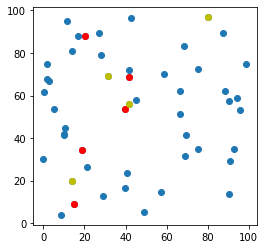

In [214]:
plt.figure(figsize=(4, 4))
plt.plot(x_y[:, 0], x_y[:, 1], 'o')
plt.plot(locations[0:N_s,0],locations[0:N_s,1],"ro")
plt.plot(locations[N_s+1:,0],locations[N_s+1:,1],"yo")
#plt.plot((110,0),(0,110))
plt.show()

In [218]:
x = x_y[:, 0]
y = x_y[:, 1]
loc_x = locations[:, 0]
loc_y = locations[:, 1]
#loch_x = locations_h[:, 0]
#loch_y = locations_h[:, 1]

In [219]:
#避難所と住民の距離
di = np.sqrt((x[:, np.newaxis] - loc_x[np.newaxis, :]) ** 2 +(y[:, np.newaxis] - loc_y[np.newaxis, :]) ** 2 )
di = di.astype(np.int64)
a = np.zeros((N,1),dtype=np.int64)
di = np.concatenate([a,di],axis=1)

## SCOPで最適化

In [220]:
from scop import *

In [221]:
m = Model()

In [223]:
#距離のコスト C
#添字0は自宅に留まる選択肢
C = di
C

array([[  0,  68,  44,  18,   3,  26,  39,  16,  59,  45,  10],
       [  0,  25,  19,  46,  56,  61,  36,  48,  17, 104,  50],
       [  0,   0,  25,  51,  65,  78,  59,  53,  10, 109,  62],
       [  0,  25,   0,  28,  41,  53,  36,  31,  15,  87,  36],
       [  0,  51,  28,   0,  14,  39,  39,   2,  42,  58,  17],
       [  0,  65,  41,  14,   0,  28,  39,  12,  56,  47,  10],
       [  0,  78,  53,  39,  28,   0,  27,  38,  68,  60,  21],
       [  0,  59,  36,  39,  39,  27,   0,  40,  48,  82,  28],
       [  0,  53,  31,   2,  12,  38,  40,   0,  45,  56,  16],
       [  0,  10,  15,  42,  56,  68,  48,  45,   0, 101,  52],
       [  0, 109,  87,  58,  47,  60,  82,  56, 101,   0,  56],
       [  0,  62,  36,  17,  10,  21,  28,  16,  52,  56,   0],
       [  0, 108,  88,  59,  50,  67,  87,  56, 101,  10,  59],
       [  0,   8,  32,  58,  72,  84,  63,  61,  16, 117,  69],
       [  0,  78,  53,  40,  31,   3,  25,  40,  68,  63,  23],
       [  0,  33,  11,  32,  41,  46,  2

In [225]:
#D[k,l]
D = np.zeros((N_sh,N_sh),dtype=np.int64)
for i in shelters:
    for j in shelters:
        if i == j:
            D[i,j] = 1
        else:
            D[i,j] = 0
D

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [226]:
#W[i,j]
W = np.zeros((N,N),dtype=np.int64)
for i in people:
    for j in people:
        w1 = max(infec_rate[j] - infec_rate[i],0) * mort_rate[i] + max(infec_rate[i] - infec_rate[j],0) * mort_rate[j]
        w2 = (infec_rate[j] - infec_rate[i]) ** 2
        W[i,j] = w1*w2/100
W

array([[  0,   0,   0, ...,   0,  92, 239],
       [  0,   0,   0, ...,   2,  80, 175],
       [  0,   0,   0, ...,   1, 109, 259],
       ...,
       [  0,   2,   1, ...,   0, 329, 960],
       [ 92,  80, 109, ..., 329,   0,  24],
       [239, 175, 259, ..., 960,  24,   0]])

### 人iを変数x[i]として、施設kの集合をドメインとする

In [227]:
x={}
for i in people:
    x[i] = m.addVariable(name = 'x[%s]'%i ,domain = shelters)

### 目的関数(二次制約クラスQuadratic)
#### W[i,j] D[k,l] (X[i]=k) (X[j]=l)の合計の最小化

In [228]:
obj = Quadratic('obj',weight = 1 ,
                rhs = 0, direction = '<=')
for i in people:
    for j in people:
        if i != j:
            for k in shelters:
                for l in shelters:
                    obj.addTerms(C[i,k]*W[i,j]*D[k,l],x[i],k,x[j],l)
m.addConstraint(obj)

### 　制約
#### 各避難所に割り振られる人数は、避難所の要領以下


In [229]:
UB = {}
for k in shelters:
    UB[k] = Linear("UB{%s}"%(i),
                   weight = 'inf',
                   rhs= capacity[k],
                   direction = '<=')
    for i in people:
        UB[k].addTerms(1,x[i],k)
    m.addConstraint(UB[k])
UB
#print(m)

{1: <scop.Linear at 0x7fc7b89387f0>,
 2: <scop.Linear at 0x7fc7b892f0b8>,
 3: <scop.Linear at 0x7fc7b892fc18>,
 4: <scop.Linear at 0x7fc7b888b7b8>,
 5: <scop.Linear at 0x7fc7b88f8358>,
 6: <scop.Linear at 0x7fc7b88f8eb8>,
 7: <scop.Linear at 0x7fc7b88f9a58>,
 8: <scop.Linear at 0x7fc7b88fa5f8>}

In [230]:
#print(m)

In [231]:
m.Params.TimeLimit=1
sol,violated=m.optimize()

#print (m)

print ("solution")
for x in sol:
    print (x,sol[x])
print ("violated constraint(s)")
for v in violated:
    print (v,violated[v])


 ================ Now solving the problem ================ 

solution
x[0] 1
x[1] 1
x[2] 2
x[3] 3
x[4] 3
x[5] 3
x[6] 3
x[7] 4
x[8] 4
x[9] 2
x[10] 4
x[11] 1
x[12] 2
x[13] 4
x[14] 1
x[15] 4
x[16] 8
x[17] 3
x[18] 6
x[19] 2
x[20] 2
x[21] 3
x[22] 3
x[23] 2
x[24] 1
x[25] 1
x[26] 4
x[27] 1
x[28] 2
x[29] 3
x[30] 4
x[31] 2
x[32] 3
x[33] 3
x[34] 4
x[35] 3
x[36] 2
x[37] 2
x[38] 5
x[39] 4
x[40] 3
x[41] 3
x[42] 1
x[43] 2
x[44] 4
x[45] 2
x[46] 3
x[47] 2
x[48] 1
x[49] 7
violated constraint(s)
obj 394454


In [232]:
L = [i for i in shelters]
L
#for x in sol:
#    print (x,sol[x])
#    "sol[{%s}]"%x.append()

[1, 2, 3, 4, 5, 6, 7, 8]